# Credit Risk Model - Logistic Regression

In [1]:
# Libraries

import pandas as pd # manipulação de dado em formato de dataframe
import seaborn as sns # biblioteca de visualização de informações estatísticas
import matplotlib.pyplot as plt # biblioteca de visualização de dados
import statsmodels.api as sm # biblioteca de modelagem estatística
import numpy as np # biblioteca para operações matemáticas multidimensionais
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
import plotly.graph_objs as go # gráfico 3D
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # stepwise
from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score # matriz de confusão
from sklearn.metrics import roc_curve, auc # curva roc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando o dataset

df = pd.read_csv("df.credit.risk.csv", encoding = "utf-8")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28501 entries, 0 to 28500
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idade            28501 non-null  int64  
 1   renda            28501 non-null  int64  
 2   tipo_moradia     28501 non-null  object 
 3   tempo_emprego    28501 non-null  float64
 4   finalidade_emp   28501 non-null  object 
 5   score_emp        28501 non-null  object 
 6   valor_emp        28501 non-null  int64  
 7   tx_jr_emp        28501 non-null  float64
 8   perc_comp_renda  28501 non-null  float64
 9   hist_inad        28501 non-null  object 
 10  hist_credito     28501 non-null  int64  
 11  inad             28501 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.6+ MB


## Preparação do dataset

In [3]:
# Fazendo a contagem da variável target

# Contagem absoluta
abs_count = df['inad'].value_counts()

# Contagem relativa
rel_count = df['inad'].value_counts(normalize=True)

# Concatenar as duas séries de dados
result = pd.concat([rel_count, abs_count], axis=1)

# Renomear as colunas
result.columns = ['Proporção', 'Contagem']

# Ordenar os valores pela contagem absoluta
result = result.sort_values(by='Contagem', ascending=False)

# Imprimir o resultado
print(result)

   Proporção  Contagem
0   0.782885     22313
1   0.217115      6188


In [22]:
# Outra forma de verificar a proporção da variável target
default_count = df[df["inad"] == 1]["inad"].count()
n_default_count = df[df["inad"] == 0]["inad"].count()
print("Numero de inad:", default_count)
print("Numero de nao inad:", n_default_count)
print("Percentual de inad:", default_count / (default_count + n_default_count) * 100)

Numero de inad: 6188
Numero de nao inad: 22313
Percentual de inad: 21.71151889407389


<BarContainer object of 1 artists>

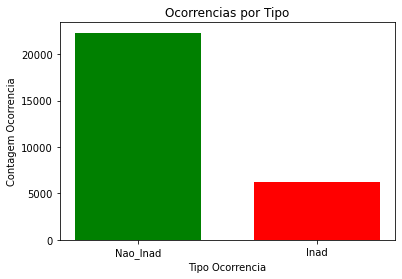

In [5]:
# Visualização Gráfica
categories = ["Nao_Inad", "Inad"]
xpos = np.array([0, 1])
plt.xticks(xpos, categories)
plt.xlabel("Tipo Ocorrencia")
plt.ylabel("Contagem Ocorrencia")
plt.title("Ocorrencias por Tipo")
plt.bar(xpos[0], n_default_count, width= 0.7, color = "g")
plt.bar(xpos[1], default_count, width = 0.7, color="r")

In [6]:
# Transformação das variáveis categóricas não binárias em dummies

# Verificando a quantidade de categorias das variáveis 
df['tipo_moradia'].value_counts()
df['finalidade_emp'].value_counts()
df['score_emp'].value_counts()
df['hist_inad'].value_counts()

# get dummies
df_dummies = pd.get_dummies(df,
                            columns=['tipo_moradia',
                                     'finalidade_emp',
                                     'score_emp',
                                     'hist_inad'],
                                      drop_first=True)

df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28501 entries, 0 to 28500
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        28501 non-null  int64  
 1   renda                        28501 non-null  int64  
 2   tempo_emprego                28501 non-null  float64
 3   valor_emp                    28501 non-null  int64  
 4   tx_jr_emp                    28501 non-null  float64
 5   perc_comp_renda              28501 non-null  float64
 6   hist_credito                 28501 non-null  int64  
 7   inad                         28501 non-null  int64  
 8   tipo_moradia_FINANCIADA      28501 non-null  uint8  
 9   tipo_moradia_OUTROS          28501 non-null  uint8  
 10  tipo_moradia_PROPRIA         28501 non-null  uint8  
 11  finalidade_emp_LAZER         28501 non-null  uint8  
 12  finalidade_emp_PESSOAL       28501 non-null  uint8  
 13  finalidade_emp_R

## Estimação do modelo logístico binário

In [7]:
# Definição da fórmula utilizada no modelo
lista_colunas = list(df_dummies.drop(columns=['inad']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "inad ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  inad ~ idade + renda + tempo_emprego + valor_emp + tx_jr_emp + perc_comp_renda + hist_credito + tipo_moradia_FINANCIADA + tipo_moradia_OUTROS + tipo_moradia_PROPRIA + finalidade_emp_LAZER + finalidade_emp_PESSOAL + finalidade_emp_REFORMA + finalidade_emp_RENEGOCIACAO + finalidade_emp_SAUDE + score_emp_B + score_emp_C + score_emp_D + score_emp_E + score_emp_F + score_emp_G + hist_inad_S


In [8]:
# Modelo
modelo_credito = sm.Logit.from_formula(formula_dummies_modelo, 
                                       df_dummies).fit()

# Parâmetros do modelo
modelo_credito.summary()

Optimization terminated successfully.
         Current function value: 0.335702
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   inad   No. Observations:                28501
Model:                          Logit   Df Residuals:                    28478
Method:                           MLE   Df Model:                           22
Date:                Tue, 21 Mar 2023   Pseudo R-squ.:                  0.3584
Time:                        19:53:54   Log-Likelihood:                -9567.9
converged:                       True   LL-Null:                       -14913.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.1785      0.197    -21.158      0.000      -4.566      -3.791
idade                          -0.0125      0.006     -1.995      0.046      -0.025      -0.000
renda                        8.763e-07   3.22e-07      2.723      0.006    2.46e-07    1.51e-06
tempo_emprego                  -0.0142      0.005     -2.831      0.005      -0.024      -0.004
valor_emp                      -0.0001   4.29e-06    -23.511      0.000      -0.000   -9.24e-05
tx_jr_emp                       0.0892      0.018      4.910      0.000       0.054       0.125
perc_comp_renda                13.1512      0.252     52.208      0.000      12.657      13.645
hist_credito                    0.0105      0.009      1.113      0.266      -0.008       0.029
tipo_moradia_FINANCIADA        -0.8258      0.043    -19.212      0.000      -0.910      -0.742
tipo_moradia_OUTROS            -0.3870      0.301     -1.285      0.199      -0.977       0.203
tipo_moradia_PROPRIA           -2.6132      0.110    -23.849      0.000      -2.828      -2.398
finalidade_emp_LAZER           -0.2675      0.067     -3.967      0.000      -0.400      -0.135
finalidade_emp_PESSOAL          0.2319      0.064      3.631      0.000       0.107       0.357
finalidade_emp_REFORMA          0.9240      0.070     13.227      0.000       0.787       1.061
finalidade_emp_RENEGOCIACAO     0.8755      0.061     14.310      0.000       0.756       0.995
finalidade_emp_SAUDE            0.7186      0.060     12.034      0.000       0.602       0.836
score_emp_B                     0.1085      0.083      1.308      0.191      -0.054       0.271
score_emp_C                     0.2372      0.125      1.901      0.057      -0.007       0.482
score_emp_D                     2.3284      0.157     14.856      0.000       2.021       2.636
score_emp_E                     2.4932      0.198     12.611      0.000       2.106       2.881
score_emp_F                     2.7882      0.273     10.208      0.000       2.253       3.324
score_emp_G                     6.3306      1.056      5.996      0.000       4.261       8.400
hist_inad_S                     0.0216      0.053      0.407      0.684      -0.083       0.126
===============================================================================================
"""

## Procedimento Stepwise

In [9]:
# Estimação do modelo por meio do procedimento Stepwise
step_modelo_credito = stepwise(modelo_credito, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 inad ~ idade + renda + tempo_emprego + valor_emp + tx_jr_emp + perc_comp_renda + hist_credito + tipo_moradia_FINANCIADA + tipo_moradia_OUTROS + tipo_moradia_PROPRIA + finalidade_emp_LAZER + finalidade_emp_PESSOAL + finalidade_emp_REFORMA + finalidade_emp_RENEGOCIACAO + finalidade_emp_SAUDE + score_emp_B + score_emp_C + score_emp_D + score_emp_E + score_emp_F + score_emp_G + hist_inad_S
Optimization terminated successfully.
         Current function value: 0.335702
         Iterations 8

 Discarding atribute "hist_inad_S" with p-value equal to 0.6843620996953587 

Estimating model...: 
 inad ~ idade + renda + tempo_emprego + valor_emp + tx_jr_emp + perc_comp_renda + hist_credito + tipo_moradia_FINANCIADA + tipo_moradia_OUTROS + tipo_moradia_PROPRIA + finalidade_emp_LAZER + finalidade_emp_PESSOAL + finalidade_emp_REFORMA + finalidade_emp_RENEGOCIACAO + finalidade_emp_SAUDE + score_emp_B + score_emp_C + score_emp_D + score_emp_E + score_emp_

In [10]:
# In[ ]: Comparando os parâmetros dos modelos

summary_col([modelo_credito, step_modelo_credito],
            model_names=["MODELO INICIAL","MODELO STEPWISE"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,MODELO INICIAL,MODELO STEPWISE
Intercept,-4.1785***,-4.5086***
,(0.1975),(0.1362)
finalidade_emp_LAZER,-0.2675***,-0.2700***
,(0.0674),(0.0674)
finalidade_emp_PESSOAL,0.2319***,0.2296***
,(0.0639),(0.0638)
finalidade_emp_REFORMA,0.9240***,0.9224***
,(0.0699),(0.0698)
finalidade_emp_RENEGOCIACAO,0.8755***,0.8724***
,(0.0612),(0.0612)


In [11]:
# In[ ]: Construção de função para a definição da matriz de confusão

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

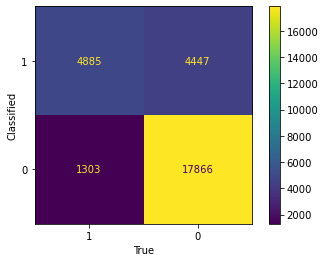

,Sensitividade,Especificidade,Acurácia
0,0.789431,0.800699,0.798253


In [15]:
# In[ ]: Construção da matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
df_dummies['phat'] = step_modelo_credito.predict()

#Matriz de confusão para cutoff = 0.5
matriz_confusao(observado=df_dummies['inad'],
                predicts=df_dummies['phat'],
                cutoff=0.20)

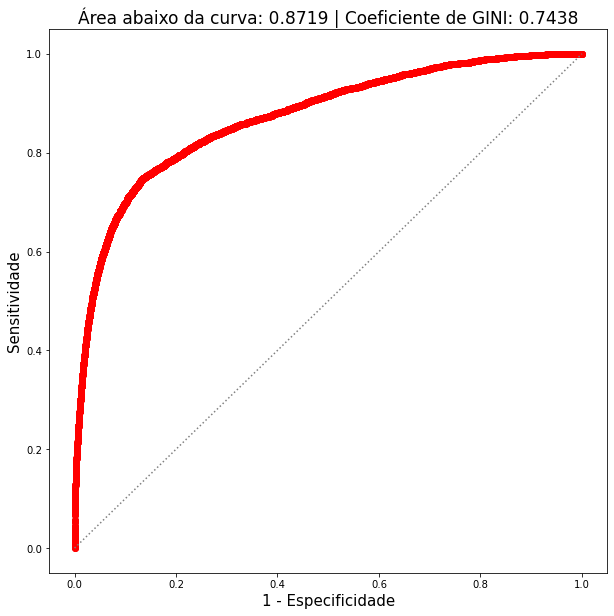

In [16]:
# In[ ]: Construção da curva ROC

#Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_dummies['inad'],
                                df_dummies['phat'])
roc_auc = auc(fpr, tpr)

#Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

#Plotando a curva ROC
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr, '-o', color='red')
plt.plot(fpr,fpr, ':', color='gray')
plt.title('Área abaixo da curva: %g' % round(roc_auc,4) +
          ' | Coeficiente de GINI: %g' % round(gini,4), fontsize=17)
plt.xlabel('1 - Especificidade', fontsize=15)
plt.ylabel('Sensitividade', fontsize=15)
plt.show()

In [17]:
# In[ ]: Igualando critérios de especificidade e de sensitividade

#Tentaremos estabelecer um critério que iguale a probabilidade de
#acerto daqueles que chegarão atrasados (sensitividade) e a probabilidade de
#acerto daqueles que não chegarão atrasados (especificidade).

#ATENÇÃO: o que será feito a seguir possui fins didáticos, apenas. DE NENHUMA
#FORMA o procedimento garante a maximização da acurácia do modelo!

#Criação da função 'espec_sens' para a construção de um dataset com diferentes
#valores de cutoff, sensitividade e especificidade:

def espec_sens(observado,predicts):
    
    # adicionar objeto com os valores dos predicts
    values = predicts.values
    
    # range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidadee = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidadee)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [18]:
# In[ ]: Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados

dados_plotagem = espec_sens(observado = df_dummies['inad'],
                            predicts = df_dummies['phat'])

dados_plotagem

,cutoffs,sensitividade,especificidade
0,0.00,1.000000,0.000000
1,0.01,0.999030,0.063192
2,0.02,0.991597,0.161027
3,0.03,0.978830,0.254695
4,0.04,0.961538,0.332855
...,...,...,...
96,0.96,0.055915,0.999776
97,0.97,0.042825,0.999821
98,0.98,0.028604,0.999910
99,0.99,0.014059,0.999910


In [19]:
dados_plotagem.head(10)

,cutoffs,sensitividade,especificidade
0,0.00,1.000000,0.000000
1,0.01,0.999030,0.063192
2,0.02,0.991597,0.161027
3,0.03,0.978830,0.254695
4,0.04,0.961538,0.332855
5,0.05,0.945217,0.397929
6,0.06,0.930026,0.455026
7,0.07,0.915320,0.501367
8,0.08,0.902553,0.540806
9,0.09,0.888332,0.577376


In [20]:
dados_plotagem.tail(10)

,cutoffs,sensitividade,especificidade
91,0.91,0.117162,0.998387
92,0.92,0.106658,0.998611
93,0.93,0.093083,0.999238
94,0.94,0.077569,0.999552
95,0.95,0.065934,0.999776
96,0.96,0.055915,0.999776
97,0.97,0.042825,0.999821
98,0.98,0.028604,0.999910
99,0.99,0.014059,0.999910
100,1.00,0.000000,1.000000


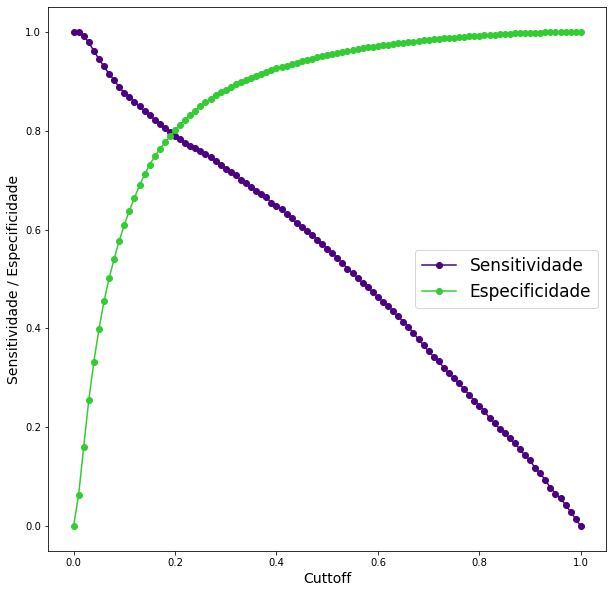

In [21]:
# In[ ]: Visualizando o novo dataframe 'dados_plotagem' e plotando os dados
#em um gráfico que mostra a variação da especificidade e da sensitividade
#em função do cutoff

plt.figure(figsize=(10,10))
plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, '-o',
         color='indigo')
plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, '-o',
         color='limegreen')
plt.legend(['Sensitividade', 'Especificidade'], fontsize=17)
plt.xlabel('Cuttoff', fontsize=14)
plt.ylabel('Sensitividade / Especificidade', fontsize=14)
plt.show()

# Fim